# FAKE NEWS DETECTION MODEL

### Loading Dataset from .csv file

The following project was inspired by *kaggle.com*, and the dataset used for modelling was from their website. Our original dataset, *original_news.csv*, contains 4 columns. These columns consist of an ***ID*** number, the ***title*** of the new article, the ***text*** of the whole article and the target ***label*** for modelling purposed. We will proceed with the importing of the appropriate packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pyplot
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import csv
import os
import ast
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV

c:\Users\Daniel H\miniconda3\envs\fakenews_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we shall now load the original dataset into python. The head of the pandas dataset is presented below. 

In [3]:
dataset = pd.read_csv('original_news.csv') #create pandas dataframe using .csv file
display(dataset.head()) #display top 5 entries

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Before we proceed, we must ensure that all duplicates are removes from the dataset. On the *kaggle* website, where I obtained the dataset, the page corresponding to this data contained a brief summary of the whole dataset. Viewing this I discovered that multiple datapoints existed with identical values. In order to avoid the possibility of oversaturating out predictive models with multiple datapoint of identical values, we must remove them. Once this simply bit of data cleaning is finished, we may proceed to explore our data. The number of duplicate data points removed is 29.

In [4]:
dataset = dataset.drop_duplicates(subset = ['title','text']) #remove duplicates if they share the same values for 'title' AND 'text'

## Exploratory Data Analysis

To further expand the search for possible correlations to create a more reliable predictive model for this project, we shall introduce some more metrics for each item in our dataframe. We shall introduce the features, ***title_word_count*** and ***text_word_count***. As these names may suggest, they are simply the number of words present within the ***title*** and ***text*** respectively.

In [9]:
dataset['title_word_count'] = dataset['title'].str.split().apply(len) #from 'title', convert to string, split string to list and apply length to list
dataset['text_word_count'] = dataset['text'].str.split().apply(len) #from 'text', convert to string, split string to list and apply length to list

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317


These new metrics that we have evaluated are now prime subjects to perform some basic exploratory data analysis upon them to discover how each data series is distributed across our whole dataset. For now we shall create histograms for each group of data to discover a distribution for each and evaluate their basic properties, such as their mean and variance. 

In [138]:
def mean_and_variance(input_dataset,column_label):
    data = input_dataset[column_label]
    mean = sum(data)/len(data)
    variance = np.var(data)
    print(f'Mean of \'{column_label}\' data: {mean},\n')
    print(f'Variance of \'{column_label}\' data: {variance}.\n')
    return mean, variance

title_word_count_metrics = mean_and_variance(dataset,'title_word_count')
text_word_count_metrics = mean_and_variance(dataset,'text_word_count')

Mean of 'title_word_count' data: 10.495876942594355,

Variance of 'title_word_count' data: 15.879542150413489.

Mean of 'text_word_count' data: 776.3495084046939,

Variance of 'text_word_count' data: 732167.4376282074.



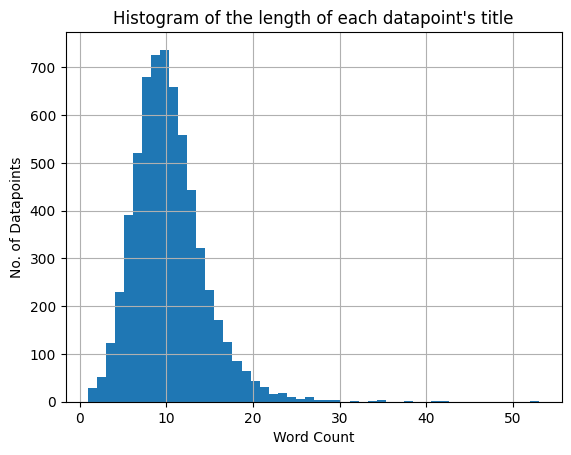

In [10]:
dataset['title_word_count'].hist(bins=50) #histogram of bin number equal to 50 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s title') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

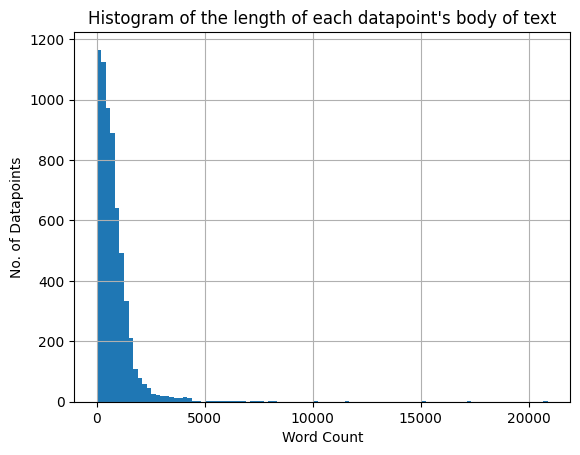

In [13]:
dataset['text_word_count'].hist(bins=100) #histogram of bin number equal to 100 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s body of text') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

The mean and variance of the ***title_word_count*** data seem relatively normal. This is reinforced when observing the histogram of this data. The distribution peaks around the mean, roughly, and the spread of data seems reasonable, if we exclude the fact that our variable cannot be negative in value. However,we start to see irregularities when observing the metrics for the ***text_word_count*** data. The mean again seems relatively standard when compared with the histogram. However, the variance is extremely high. Obervation on the respective histogram revelas that there exists numerious data point where the number of words in the main body of text of the new article exceed 10,000 words! This will naturally overwhelm the variance value with our mean being relatively so small compared. All the datapoints that exceed this 10,000 word count margin are shown below.

In [141]:
display(dataset[dataset['text_word_count'] > 10000]) #show all extreme values for 'text_word_count' length

,Unnamed: 0,title,text,label,title_word_count,text_word_count
536,9618,President Putin Asks US To Stop Provoking Russia,Here is President Putin’s speech at Valdai Put...,FAKE,8,11662
1359,5604,Benny Morris’s Untenable Denial of the Ethnic ...,References The Debate \nIt started when Daniel...,FAKE,10,15199
3436,5765,Re: It Is Now Mathematically Impossible To Pay...,It Is Now Mathematically Impossible To Pay Off...,FAKE,13,17332
3685,8441,Re: America Has Become A Lawless Nation – Hill...,America Has Become A Lawless Nation – Hillary ...,FAKE,15,10090
4733,7910,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,FAKE,13,20891


From this we can make our first discovery about the dataset. Every data point that exceeds the 10,000 word count is classified as **FAKE**. We can use this observation later whose we have developed our first predictive models to see if they have also observed this trend and used this. An observation like this would work incredibly well in a modelling process such as a *decision tree* model. We could now do something smilar with the ***title_word_count*** now to see if any patterns like this can be discovered. Let us ask if data points with ***title_word_count*** values exceeding 30 are typically classified as **FAKE**.

In [142]:
display(dataset[dataset['title_word_count'] >= 30])

,Unnamed: 0,title,text,label,title_word_count,text_word_count
261,7892,Comment on Breaking: CDC Blocks Testimony of T...,Have you heard of Dr. William Thompson? If y...,FAKE,35,919
436,6329,Muslims regularly use “Inshallah” (“God Willin...,BNI Store Nov 5 2016 Muslims regularly use “In...,FAKE,30,665
1041,5939,Comment on The Science is “Overwhelming At Thi...,This ordinance is a big step forwards by cre...,FAKE,34,2513
1073,7560,Comment on ‘Voting Is Rigged & Used To Pacify ...,Share on Facebook Share on Twitter “This is th...,FAKE,38,1360
1208,5420,12 and 63-minute videos: Donald Trump connects...,"Posted on November 7, 2016 by Carl Herman \nJo...",FAKE,35,1421
1562,7769,Comment on Canadian Air Force Pilot Snaps A Pi...,Share on Facebook Share on Twitter “If it does...,FAKE,32,1077
1580,6031,Comment on Hillary Clinton failed to disclose ...,DCG | 2 Comments \nRules are for little peop...,FAKE,42,730
1663,9064,"Life: If You Love Enamel Pins, You’ll Love Thi...","Email If you can’t get enough enamel pins, the...",FAKE,53,375
2763,8341,Comment on Shocking Insinuation About Carl Sag...,Share on Facebook Share on Twitter A few years...,FAKE,32,3009
3607,6321,Queen Elizabeth II owns every dolphin in Brita...,Email \nQueen Elizabeth II is not like you and...,FAKE,30,2887


As we can see, all 15 data points that have title lengths that exceed or are equal to 30 words are all classified as **FAKE**. This can also be used to determine the success of any models that we evaluate in the future. These finds give us promise that correlations exist within the dataset to allow us to create a reliable prodictive model. Now that we have these findings, we are presented with another question that must be asked; Is there a need for the ***title*** and ***text*** data now? Have we extracted all infomation that may prove usful for our model? No. There still exists relavent information within these string data values. For instance, two of the joint most numerius data values associated with the *title* column are 'OnPolitics | 's politics blog' and 'Michael Moore Owes Me $4.99'. When we display all their respective datapoint out we observe that even though they have the same amount of ***title_word_count*** value, their ***label*** values are mutual exclusive from one another.

Text(0.5, 1.0, 'Scatter plot for title/text pairs')

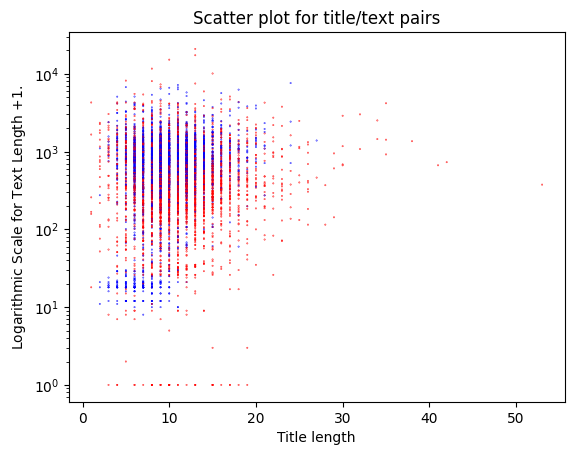

In [264]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
scatter = pyplot.scatter(dataset['title_word_count'],dataset['text_word_count']+1, c = dataset['label'].map(colour), s=0.4, marker='.')
pyplot.xlabel('Title length')
pyplot.ylabel('Logarithmic Scale for Text Length $+ 1$.')
pyplot.yscale('log')
pyplot.title('Scatter plot for title/text pairs')

As we can see from the scatter plot above, some logic is present regarding determining **FAKE** and **REAL** news. Outlier datapoints where ***title_Word_count*** and ***text_word_count*** is either too high or too low are typically labels as **FAKE**. However, a closed form structural review for all datapoints still eludes us. **REAL** and **FAKE** datapoints cluster around eachother, so we can conclude that evaluating just the word count for the tile and the main text of each news article is not enough to reliable predict when the datapoint is within this cluster. So we shall now implement a new metric for our data. We shall implement a sentiment analysis model to out datapoints to get a metric of how possitive or negative an article is. Perhaps a negative article is more likely to be fake than real.

In [243]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #tokenizer converts text into series of numerical values
sentiment_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #load pretrained sentiment model 

def sentiment_score(text): #define function to get sentiment score from model
    tokens = tokenizer.encode(text,return_tensors='pt') #tokenizer encodes given text into numerical values, returned in a pytorch tensor
    output = sentiment_model(tokens) #feed tokenizer data into model
    return int(torch.argmax(output.logits))+1 #convert output array into scores 1,2,3,4 and 5

dataset['title_sentiment_score'] = dataset['title'].apply(lambda x: sentiment_score(x)) #apply function to all title data
dataset['text_sentiment_score'] = dataset['text'].apply(lambda x: sentiment_score(x[:512])) #sentiment model is limited with how many tokens it can process at one time, specifically it is 512, so using only 512st words in text for evaluating

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count,title_sentiment_score,text_sentiment_score
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296,5,4
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446,1,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431,4,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404,1,1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317,4,4


In [344]:
title_ss_array = dataset['title_sentiment_score']
text_ss_array = dataset['text_sentiment_score']
title_lengths = dataset['title_word_count']
text_lengths = dataset['text_word_count']

r = np.corrcoef([title_lengths, text_lengths, title_ss_array, text_ss_array]) #Correlation-Coefficient Matrix of all desired variables

print(f'The Correlation-Coefficient Matrix for our 4 evaluated features:\n {r}, \n')

print(f'Correlation-Coefficient between our sentiment scores: {r[3,2]}, \n')

print(f'Correlation-Coefficient between title and text word count: {r[1,0]}.')

The Correlation-Coefficient Matrix for our 4 evaluated features:
 [[ 1.          0.03668925 -0.12064946 -0.07445042]
 [ 0.03668925  1.          0.04231625  0.03485658]
 [-0.12064946  0.04231625  1.          0.2874482 ]
 [-0.07445042  0.03485658  0.2874482   1.        ]], 

Correlation-Coefficient between our sentiment scores: 0.2874481953331301, 

Correlation-Coefficient between title and text word count: 0.036689254710973014.


The above correlation-coefficients yield the desired values. The magnitutde of every correlation coefficient between each feature does not exceed $0.3$, meaning that there does not exist any significant correlation between our intended numerical features for predictive models. This is what we desire. If our features are too correlated with each other, then our models are suseptible to overfitting to data that does not contribute any new insight into our models. What we desire, is for features to correlate with the target label (which we will discover via modelling) and that they arre appropriatly chosen features for our label (since they are all derived directly from the text data which encompasses the text's length and, in a sense, meaning beind the words we can be safe in calling them appropriate for our use).

This sentiment model scores using a scale from 1 to 5, with 1 corresponding with a negative sentiment and 5 being a positive sentiment. However, we have had to make a concession regarding the ***text*** data when evaluating it's sentiment score. Due to limitations with the sentiment model we are using, only the first 512 tokens of text can be used to assess the whole text's sentiment score. This may lead to sentiment scores not reflecting the true score of a body of text, but typically the beginning of an article sets a specific tone for the remainder of the text. This could be in the for or a intorduction which goes over what will be discussed or if its simply stating the purpose of the text. So for our analysis, we will have to assume the following: **The sentiment score for the text for each datapoint remains constant through the text itself**. We will perform this sentiment analysis on both the ***title*** and ***text***. The motivation behind this is that correlation may exist between the ***label*** and the difference in sentiment score between the title of an article and the main body of text, as a form of *click-baiting*. Furthermore, we want to see if our hypothesis is true that negatively sentimented articles are more likely to be ***FAKE***. We could also assess whether extreme sendiment scores on either side of neutral (1 or 5) correlate with labelling articles fake or not, to play to a specific audiance's emotions about a specific issue to get more view.

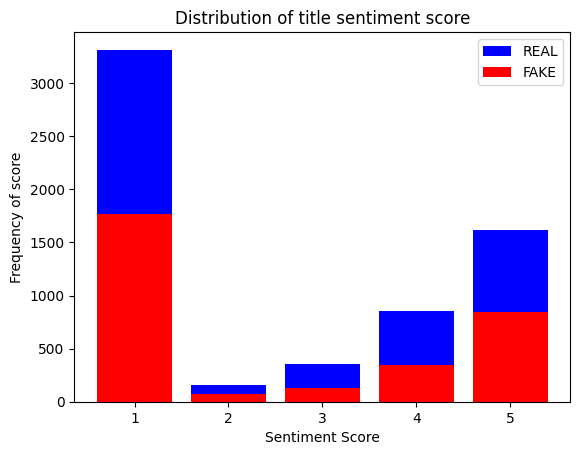

In [281]:
classes = [1,2,3,4,5] 
real_scores = []
fake_scores = []
for score in range(1,6,1):
    real_scores.append(len(dataset[(dataset['title_sentiment_score'] == score) & (dataset['label'] == 'REAL')]))
    fake_scores.append(len(dataset[(dataset['title_sentiment_score'] == score) & (dataset['label'] == 'FAKE')]))

fig, ax = pyplot.subplots()

for item in range(len(real_scores)):
    real_scores[item] = fake_scores[item] + real_scores[item]

ax.bar(classes,real_scores,label='REAL',color='blue')
ax.bar(classes,fake_scores,label='FAKE',color='red')

ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency of score')
ax.set_title('Distribution of title sentiment score')
ax.legend()
pyplot.show()

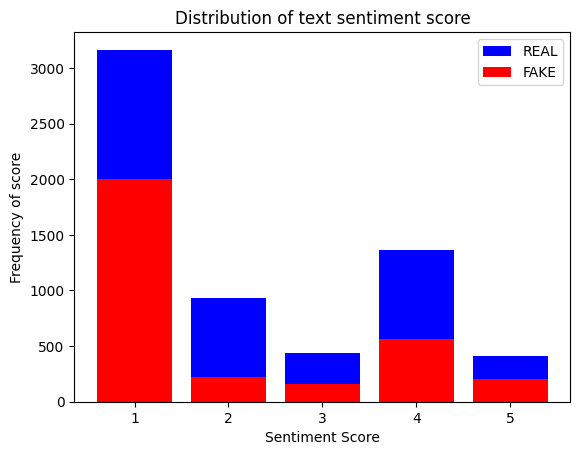

In [282]:
classes = [1,2,3,4,5] 
real_scores = []
fake_scores = []
for score in range(1,6,1):
    real_scores.append(len(dataset[(dataset['text_sentiment_score'] == score) & (dataset['label'] == 'REAL')]))
    fake_scores.append(len(dataset[(dataset['text_sentiment_score'] == score) & (dataset['label'] == 'FAKE')]))

fig, ax = pyplot.subplots()

for item in range(len(real_scores)):
    real_scores[item] = fake_scores[item] + real_scores[item]

ax.bar(classes,real_scores,label='REAL',color='blue')
ax.bar(classes,fake_scores,label='FAKE',color='red')

ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency of score')
ax.set_title('Distribution of text sentiment score')
ax.legend()
pyplot.show()

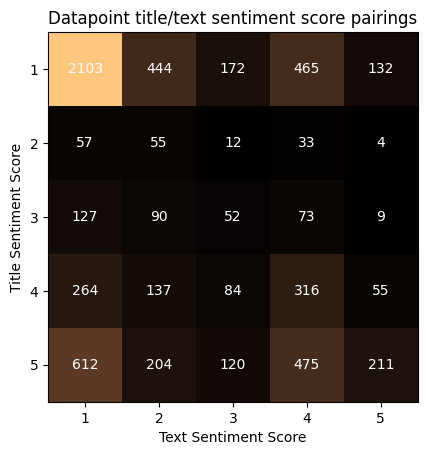

In [306]:
title_score_classes = ['1','2','3','4','5']
text_score_classes = ['1','2','3','4','5']

f = lambda i, j: len(dataset[(dataset['title_sentiment_score'] == i+1) & (dataset['text_sentiment_score'] == j+1)])
score_matrix = np.fromfunction(np.vectorize(f), (5,5), dtype=int)

fig, ax = pyplot.subplots()
im = ax.imshow(score_matrix,cmap = 'copper')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(title_score_classes)), labels=title_score_classes)
ax.set_yticks(np.arange(len(text_score_classes)), labels=text_score_classes)

# Loop over data dimensions and create text annotations.
for i in range(len(title_score_classes)):
    for j in range(len(text_score_classes)):
        text = ax.text(j, i, score_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Datapoint title/text sentiment score pairings")
pyplot.xlabel('Text Sentiment Score')
pyplot.ylabel('Title Sentiment Score')
pyplot.show()

Note that a significant proportion of sentimental scores for both title and text are valued at 1. This can be explained as news outlets reference to use negative language to attract the attention of viewers so as to gain an increase in footfall on their respective websites. However, we must be ever aware of the assumption we have made regarding the sentiment score of the text of the article. We may also be experiencing an inflation in negatively sentimented scores due to articles possibly being written more negatively than what the whole article actually reflects to keep viewers reading. But, the proportion of **REAL** and **FAKE** new articles across all scores for both title and text data is promising for us and our models when training. We do not want to accidentaly train our models on data that is entirely fake for a certain sentiment score, this would lead to our models creating an untrue correlation and would yield unfavourable predictions. 

In [621]:
def save_csv_data(dataset):
    dataset.to_csv('cleaned_news.csv',index=False)
    return

save_csv_data(dataset)

### Normalising Feature Data

Title length resembles a normal distribution with mean, $10.5$, and variance, $15.9$. So convertion using $Z$-scores should be fine. Using the formula;

$$
z_i = \frac{x_i - \mu}{\sigma},
$$ 

we can convert our *title_word_count* data. As for our *text_word_count* data, since it spans multiple orders of magnitude and seemingly follows a power law, we can apply a $log$ function to the data and observe the distribution. Indeed,

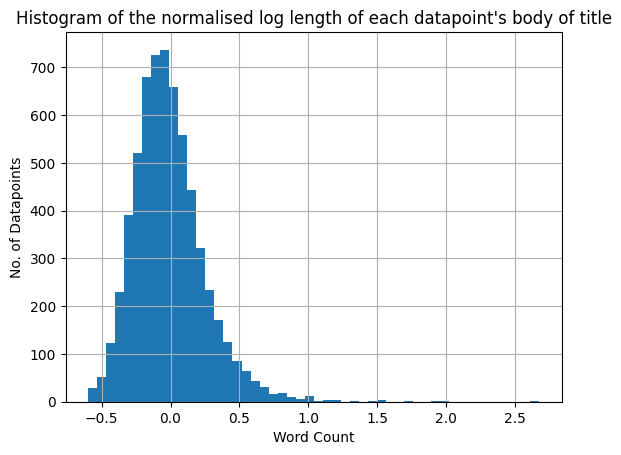

In [618]:
dataset = pd.read_csv('cleaned_news.csv')

title_word_count = dataset['title_word_count']

mean = sum(title_word_count)/len(title_word_count)
variance = np.var(title_word_count)

normal_title_word_count = title_word_count.apply(lambda x: (x-mean)/variance)

normal_title_word_count.hist(bins=50)
pyplot.title('Histogram of the normalised log length of each datapoint\'s body of title') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

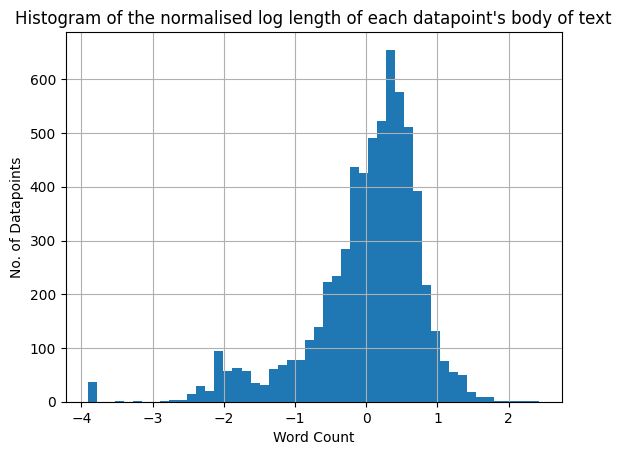

In [617]:
dataset = pd.read_csv('cleaned_news.csv')

log_text_word_count = (dataset['text_word_count']+1).apply(np.log)

mean = sum(log_text_word_count)/len(log_text_word_count)
variance = np.var(log_text_word_count)

normal_log_text_word_count = log_text_word_count.apply(lambda x: (x-mean)/variance)

normal_log_text_word_count.hist(bins=50)
pyplot.title('Histogram of the normalised log length of each datapoint\'s body of text') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label
pyplot.show()

Now that we have our normalised data, we shall create respective columns to store them in the dataset.

In [619]:
dataset['normal_title_word_count'] = normal_title_word_count
dataset['normal_log_text_word_count'] = normal_log_text_word_count
save_csv_data(dataset)

### Topic Modelling

LDA? BERTopic?

## Modelling

### Baseline models

The gauge the success of our models, we will present a baseline model to compare future classification models with. The standard baseline model that we could us takes the form of a uniform random coin-toss. Since our models will be determining the ***label*** of a data point, which can only take the classes **REAL** or **FAKE**. Thus, a model that chooses between these two classes with equal probability can be expected to get an accuracy score of $50$%. So for future models that we derive, if they are an improvement upon an accuracy score of $50$%, we could begin to consider the effectiveness of this model.

### Custom Model (Dimensional Expansion)

Motivated by the scatter plot that compared the distibution of log text length and title length pairings, a possible simple approach to determining the correct label for a given pairing is by extending this plot into a higher dimension which separates the two clusters of true labeled data points. Suppose that our title/text pairings are of the form $(x,y)$. Then, we seek to find a mapping $f(x,y)$ such that,

$$
\left(x,y\right) \longrightarrow{} \left(x,y,f(x,y)\right).
$$

This mapping function could take any deterministic form. However, for this example we can suppose a relatively simple function for separating differntly labeled data points $(x,y)$. The function we will use is of the form,

$$
f(x,y) = \sum_{i=1}^{N_{\text{cluster}}} \frac{1}{\alpha_{i}(\hat{x}_i-x)^2+\beta_{i}(\hat{y}_i-y)^2},
$$

where $N_{\text{cluster}}$ is the number of clusters we want to sperate from the rest of the data, $(\hat{x}_i,\hat{y}_i)$ is the center of each cluster and the constants $\alpha_{i}, \beta_{i}$ are amplifiers to allow us to extend our surface in an elliptical manner. This is important since our clusterings in our original scatter plot are not perfect circles, they appear to be elliptical, thus these constants allow us flexibility into what we extend abow for separation. To determine how we classify labels after this dimensional expension, we introduce a plane, $c(x,y)$. This curve can also take an arbitrarily complex form we desire. However, for a simple model we can take this to be a flat plane or even a constant function. For a flat plane function, $c(x,y)$ takes the form, 

$$
c(x,y) = ax+by+c, \text{ where  }a,b,c \in \mathbb{R}.
$$

Once we have established these functions, we can construct the methods for determining labels for our model. Indeed, since we are trying to extend the dimensionality such that we seperate 'REAL' and 'FAKE' news articles where 'REAL' data points are located above our iontersection curve $c(x,y)$, then our classification model takes the form,

$$
f(x,y) > c(x,y) \implies \text{label}(x,y) = \text{'REAL'},
$$

otherwise $\text{label}(x,y) = \text{'FAKE'}$. To help visualise the dimensional extension for our system of points, observe the plot below that shows how we can *pull* the surface lift it above the resting area. Then we can say that if a data point is above the resting surface by a certain amount, we classifiy it as real or fake.

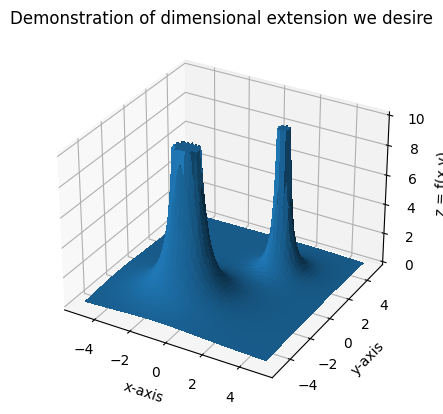

In [141]:
ax = pyplot.figure().add_subplot(projection='3d')

X = np.linspace(-5, 5, 5000)
Y = np.linspace(-5, 5, 5000)
X_mesh, Y_mesh = np.meshgrid(X, Y)
Z =  1/(0.2*(-1-X_mesh)**2+0.3*(-2-Y_mesh)**2) + 1/((2-X_mesh)**2+(2-Y_mesh)**2)
for i in range(len(X)):
    for j in range(len(Y)):
        if Z[i,j] > 10:
            Z[i,j] = 10

ax.plot_surface(X_mesh, Y_mesh, Z, linewidth=0, antialiased=False)
ax.set_zlim(0,10)
pyplot.title('Demonstration of dimensional extension we desire')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z = f(x,y)')
pyplot.show()

In [68]:
dataset = pd.read_csv('cleaned_news.csv')

X = dataset[['title_word_count','text_word_count','title_sentiment_score','text_sentiment_score']]
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) #to create a 60-20-20 split in data sets

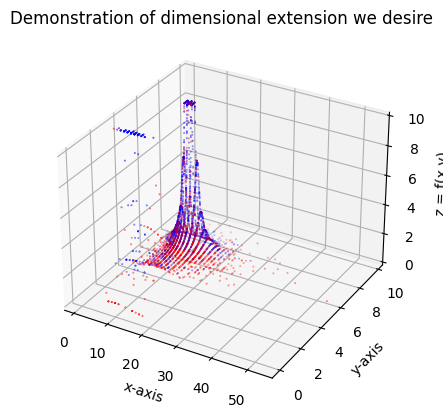

In [137]:
ax2 = pyplot.figure().add_subplot(projection='3d')

X = X_train['title_word_count']
Y = X_train['text_word_count']
Z =  50/(2*(10-X)**2+0.0001*(1000-Y)**2) + 1/(0.001*(6-X)**2+0.01*(19.5-Y)**2)
for item in range(len(Z)):
    if Z[item] > 10:
        Z[item] = 10 

colour = {'REAL': 'blue', 'FAKE': 'red'}
ax2.scatter(X, np.log(Y + 1), Z, c = y_train.map(colour).to_list(), s=0.4, marker='.')
ax2.set_zlim(0,10) 
pyplot.title('Demonstration of dimensional extension we desire')
ax2.set_xlabel('x-axis')
ax2.set_ylabel('y-axis')
ax2.set_zlabel('z = f(x,y)')
pyplot.show()

The above scatter plot uses the training data for modeling to display how data points a distributed across space given a dimenional expansion function $f$. IF we observe this scatter plot, we notice that most of the data points classifier as 'REAL' (blue) have been transformed above the x-y plane that the original scatter point inhabits. For our simple model we can take the curve that we will judge the label of a dat point to be constant. Optimisation for choosing the best constant value to use could be implemented, however this approach is intended to be base model so getting the best model is not required. We shall use $c(x,y) = 1$ to evaluate the label of a data point. Thus, roughly estimating the constant values for the function, we get that for a data point to be classified as 'REAL', the following inequality must be satisfied;

$$
\frac{50}{2(10-x)^2+0.0001(1000-y)^2} + \frac{1000}{(6-x)^2+10(19.5-y)^2} \geq 1.
$$

Now that we have the method for modelling labels, we cna implement it for our validation set to evaluate the accuracy of our model. Indeed;

In [140]:
def custom_model(X_valid, y_valid):
    x = X_valid['title_word_count']
    y = X_valid['text_word_count']
    label_df = 50/(2*(10-x)**2+0.0001*(1000-y)**2) + 1000/((6-x)**2 + 10*(19.5-y)**2)
    label_df['label'] = label_df.apply(lambda x: 'FAKE' if x < 1 else 'REAL')

    prediction = label_df['label']
    matching_df = (prediction == y_valid)
    correct_num = (matching_df == True).sum()
    incorrect_num = (matching_df == False).sum()
    accuracy = correct_num/(correct_num + incorrect_num)
    print(f'Accuracy of our custom model: {accuracy}.')
    return

custom_model(X_valid,y_valid)

Accuracy of our custom model: 0.6661379857256146.


We get that our model has an accuracy rating from the validation set of $66.6$%. This is surpisingly high considering the models that are about to follow. This is especially significate considering the only features used to assess whether a news article is fake or real is the length of the word count of the title and the text. However, this appraoch has its flaws. Firstly, there is nothing stopping a fake news article from having the same number of words as a real website. So if this was assess after all websites, we would undoubtedly encounter enough websites that share the properties that our models relies on to invalidate our model. Furthermore, our initial assumption that real news articles coalesce around certain points is based upon the scatter plot of ALL the data, which includes the validation and test sets. This could be construded as cheatig since we already know how the validation and test sets will behave. These sets are meant to be completely unknown to our model, yet they are used in the fundamental principles of it. To recify this, we should of only observed the training data in the construction of this model.

### Logistic Regression

Now that we have our data prepared, we shall begin by splitting our data into the training, validation and test sets, each with the appropriate features and labels. After the partition of for our modeling, we shall implement the Logistic Regression along with a Grid Search to fins the optimal hyperparameters from a given parameter directory. The best parameters for our model and the corresponding model metrics are presented below. 

In [580]:
def run_model(model_class, hyper_dict):
    model = model_class() #logistic model
    gridsearch = GridSearchCV(model,hyper_dict) #perform gridsearch for the all model settings
    fit_model = gridsearch.fit(X_train,y_train) #fit using training sat
    best_estimator = fit_model.best_estimator_ #best estimator from all permutations of settings

    prediction = best_estimator.predict(X_valid) #predict using validation set

    precision_value = precision_score(y_valid,prediction,average='weighted',zero_division=0) #precision score
    recall_value = recall_score(y_valid,prediction,average='weighted',zero_division=0) #recall score
    f1_value = f1_score(y_valid,prediction,average='weighted') #f1 score
    accuracy_score = best_estimator.score(X_valid,y_valid) #accuracy score
    cf = confusion_matrix(y_valid,prediction) #confusion matrix
    cf_plot = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = best_estimator.classes_) #class to display confusion matrix

    metric_dict = {
        'Accuracy': accuracy_score,
        'Precision Score': precision_value,
        'Recall Score': recall_value,
        'F1 Score': f1_value
    }

    print('MODEL METRICS')
    print('-------------\n')
    print(f'Model Parameters: {best_estimator.get_params()}.\n')
    print(f'Accuracy Score: {accuracy_score},\nPrecision Score: {precision_value},\nRecall Score: {recall_value},\nF1 Score: {f1_value}.')
    print('Confusion Matrix:')
    display(cf_plot.plot())

    dir_name = type(model_class()).__name__ #return name of model from class    
    try:
        os.mkdir(f'{dir_name}/')
    except:
        pass
    joblib.dump(best_estimator,f"{dir_name}/model")

    with open(f"{dir_name}/parameters.json", "w") as f:
        json.dump(best_estimator.get_params(), f)

    with open(f"{dir_name}/metrics.json", "w") as f:
        json.dump(metric_dict, f)
    
    if 'confusion_matrix.png' in os.listdir(f'{dir_name}'):
        os.remove(f'{dir_name}/confusion_matrix.png')
        cf_plot.figure_.savefig(f'{dir_name}/confusion_matrix.png')
    return

MODEL METRICS
-------------

Model Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}.

Accuracy Score: 0.6137985725614592,
Precision Score: 0.614114231690333,
Recall Score: 0.6137985725614592,
F1 Score: 0.6138170312849305.
Confusion Matrix:


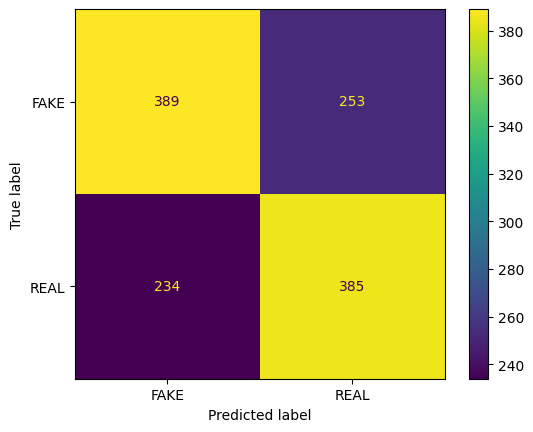

In [579]:
#Logistic Regression Classifier
hyper_dict = {
    'C': [1,0.5,0.1],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky','saga','sag'],# excluding 'newton-cg' solver as its unable to converge to best fit line
    'multi_class': ['auto','ovr'], #excluding multinomial due to incompatability with 'liblinear' solver
    'max_iter': [1000000] #to remove warning messages
}

run_model(LogisticRegression,hyper_dict)

Compared to our theoretical baseline model, we see an increase in the accuracy for correct predictions by about $11.4$%, with the overall accuracy of our logistic regression model at $61.38$%. We can also notice that the recall and precision scores for our model are very similar, showing that our model holds no favouratism towards false-positive or false-negative. This is reflected in confusion matrix displayed above. The values for correct and incorrect predictions for each class is very similar. This also reassures us that the number of real and fake news articles used to fit and assess the model are roughly split 50-50. This exposer to equal amounts of each class causes our model to create healthy connections with the data which gives our model a better chance of avoiding predictions incorrectly due to a lack of training data of that class.

### Decision Tree

MODEL METRICS
-------------

Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}.

Accuracy Score: 0.6336241078509119,
Precision Score: 0.6336241078509119,
Recall Score: 0.6336241078509119,
F1 Score: 0.6336241078509119.
Confusion Matrix:


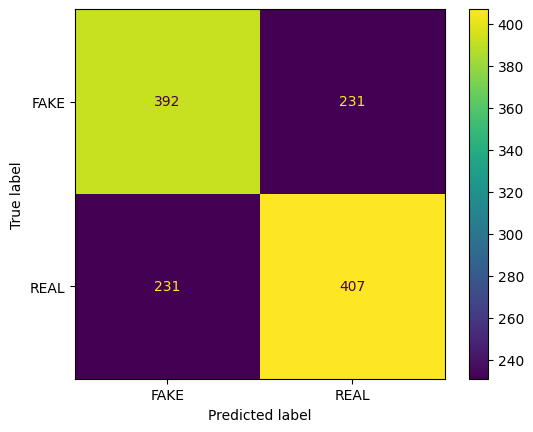

In [625]:
#Decision Tree Classifier
hyper_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best','random'],
    'min_samples_split': [1, 2, 3],
    'random_state': [42]
}

run_model(DecisionTreeClassifier,hyper_dict) #random_state given to allow for reproducability of result.

With our Decision tree model, we can clearly that this model is objectively better than the logistic regression model. For instance, the accuracy of our logistic model was $61.38$%, whereas our Decision Tree model holds an accuracy of $63.36$%. Furthermore, all other metrics to evaluate the succes of our model yields better values. This improvement can clearly be seen within the confusion matrices of both models. In all diagonal entries, we see an increase in these number (remember that these represent the correct predictions). And in the other cells of the matrix, we see a decrease in all of them (the number representing the number of incorrect predictions).

### Random Forest

MODEL METRICS
-------------

Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}.

Accuracy Score: 0.6677240285487708,
Precision Score: 0.6678627602755538,
Recall Score: 0.6677240285487708,
F1 Score: 0.6674868016837615.
Confusion Matrix:


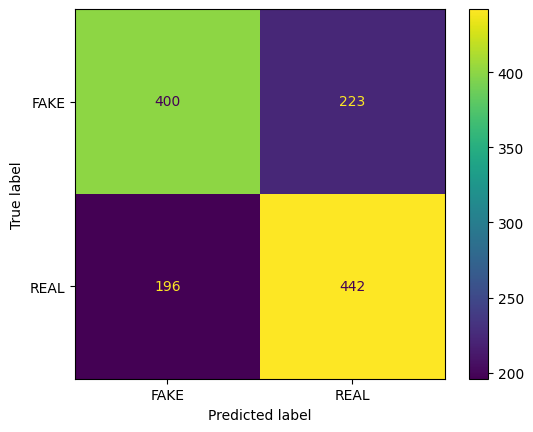

In [583]:
#Random Forest Classifier
hyper_dict = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini','entropy','log_loss'],
    'min_samples_split': [1, 2, 3],
    'random_state': [42]
}

run_model(RandomForestClassifier,hyper_dict)

### Gradient Boosting

MODEL METRICS
-------------

Model Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}.

Precision Score: 0.71725452377681,
Recall Score: 0.7168913560666138,
F1 Score: 0.7169715204300158,
Accuracy Score: 0.7168913560666138,
Confusion Matrix:


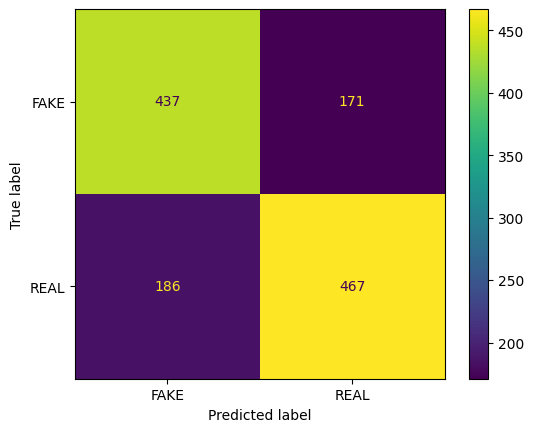

In [447]:
#Gradient Boosting Classifier
hyper_dict = {
    'loss': ['log_loss','exponential'],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'random_state': [42]
}

run_model(GradientBoostingClassifier,hyper_dict)

### AdaBoost

MODEL METRICS
-------------

Model Parameters: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 42}.

Precision Score: 0.6943081842565381,
Recall Score: 0.6938937351308485,
F1 Score: 0.6939892753579968,
Accuracy Score: 0.6938937351308485,
Confusion Matrix:


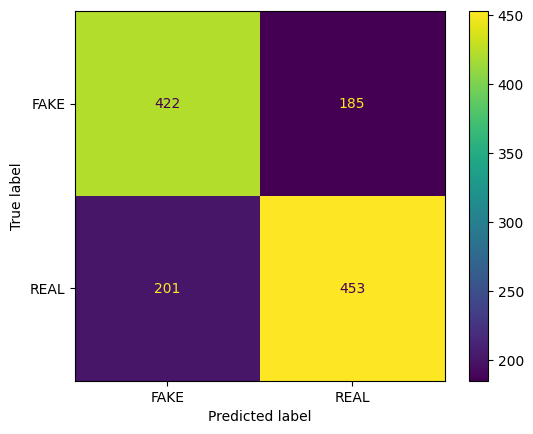

In [448]:
#Ada Boost Classifier
hyper_dict={
    'n_estimators': [50, 100, 150, 200],
    'algorithm': ['SAMME','SAMME.R'],
    'random_state': [42]
}

run_model(AdaBoostClassifier,hyper_dict)

### KNeighborsClassifier

This modelling method used basic logic about the *distance* between modelled data points and training data points to decide which class to assign to the given input data point. The *KNeighborsClassifier* from the *sklearn* package uses as default the $L_2$ distance metric (Minkowski Measure). The formula for the generalised $k^{\text{th}}$ measure is defined below; 

$$
L_k(p,q) := \left( \sum_{i=1}^{N} | p_i - q_i |^k \right)^{\frac{1}{k}}.
$$

MODEL METRICS
-------------

Model Parameters: {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 4, 'weights': 'uniform'}.

Precision Score: 0.6282680081095945,
Recall Score: 0.6249008723235527,
F1 Score: 0.6256425446580955,
Accuracy Score: 0.6249008723235527,
Confusion Matrix:


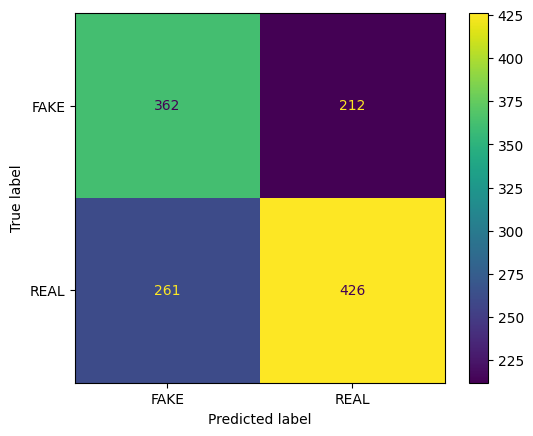

In [454]:
#K Neighbors Classifier
hyper_dict = {
    'n_neighbors': [5,7,9,11], #For Binary classification, choose k to be odd to eliminate possibility of ties
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [2,3,4,5]
}

run_model(KNeighborsClassifier,hyper_dict) #Default Minkowski metic for distance function

### MLPClassifier (Neural Network)

MODEL METRICS
-------------

Model Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10, 10, 10, 4), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}.

Precision Score: 0.6548050163587176,
Recall Score: 0.640761300555115,
F1 Score: 0.6435313776159475,
Accuracy Score: 0.640761300555115,
Confusion Matrix:


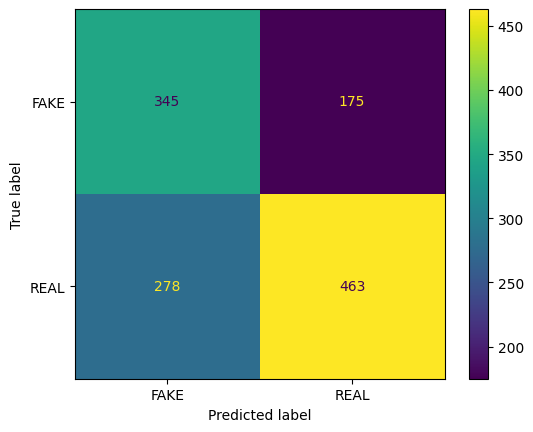

In [509]:
#MLP Neural Network Classifier
hyper_dict = {
    'hidden_layer_sizes': [(8,10,8,4),(10,10,10,4),(10,12,10,4)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant','invscaling','adaptive'],
    'max_iter': [100000],
    'random_state': [42]
}

run_model(MLPClassifier,hyper_dict)

## Best Model

Assessing the bect model has to be taken on a base-by-base situation. If we require our model to prioritise the minimisation of false-positives, say for a facial recognition model that protects very sensitive infomation, we would chose our model with the highest precision score. However, if we required a model that minimises the number of false-negatives, say a model that assess whether a produce on a conveyer system has passed a visual inspection for defects, then we would prioritise a higher recall score. For our project, we will simply assess the best model by how often it predicts correctly, the accuracy score. The accuracy scores for every model we trained during this project can be found in the table below.

|Metric|Flip-A-Coin|Custom|LogisticRegression|DecisionTree|RandomForest|GradientBoosting|AdaBoost|KNeighbors|MLP|
|----------|-|-|----------------|------------|------------|----------------|--------|----------|---|
|Accuracy  |0.500|0.666|0.614|0.634|0.668|**0.717**|0.694|0.625|0.641|

Since our *GradientBoosting* model produced the highest accuracy score for the validation data, we shall conclude that this is the best model for predicting real and fake new articles. We shall now perform predictions using this model on the unseen test dataset to make our final predictions.

TEST DATA STATISTICS
--------------------
Test Accuracy: 0.7321711568938193,
Test Precision Score: 0.7327580521513195,
Test Recall Score: 0.7321711568938193,
F1 Score: 0.732153667436342.
Confusion Matrix:


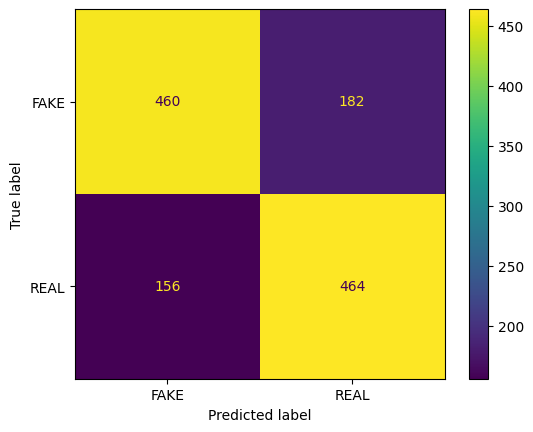

None

MODEL PARAMETERS
----------------
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: exponential
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 3
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: 42
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


In [592]:
load_model = joblib.load('GradientBoostingClassifier/model')
prediction = load_model.predict(X_test)

accuracy = load_model.score(X_test,y_test)
precision = precision_score(y_test,prediction,average='weighted')
recall = recall_score(y_test,prediction,average='weighted')
f1 = f1_score(y_test,prediction,average='weighted')
cf = confusion_matrix(y_test,prediction) #confusion matrix
cf_plot = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = load_model.classes_) #class to display confusion matrix
cf_plot.plot()

print('TEST DATA STATISTICS')
print('--------------------')
print(f'Test Accuracy: {accuracy},\nTest Precision Score: {precision},\nTest Recall Score: {recall},\nF1 Score: {f1}.\nConfusion Matrix:')
display(pyplot.show())
print('MODEL PARAMETERS')
print('----------------')
for param in load_model.get_params():
    print(f'\033[1m{param}\033[0m: '+ str(load_model.get_params()[f'{param}']))

Now that we have discovered the best performing model, we can now use the predictions made to create a visualisation of how well the model did at predicting the given test set. First, we shall see a scatter plot, like the one found at the start of this report, which plots the title lenght against the log text length with each datapoint coloured corresponding to their true labels. This plot will give us the true structure of the data and see how well our model did at discovering these structures within the data.

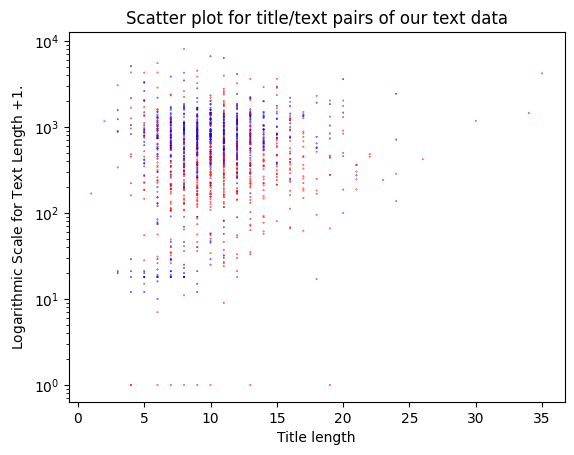

In [630]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
scatter = pyplot.scatter(X_test['title_word_count'],X_test['text_word_count']+1, c = y_test.map(colour), s=0.4, marker='.')
pyplot.xlabel('Title length')
pyplot.ylabel('Logarithmic Scale for Text Length $+ 1$.')
pyplot.yscale('log')
pyplot.title('Scatter plot for title/text pairs of our text data')
pyplot.show()

This plot shares striking resemblence to our original scatter plot for the whole dataset. We can see the main large grouping of real (BLUE) articles in the main cluster. WE can also see the off-branch below that contains mostly of real data points. Further, we see that the extreme datapoints to the right and below the main clustering are all fake (RED) articles. Using this as a informal measure of the success of our model, we can see where our modelling method discovered the correct structure and where there is room for improvement.

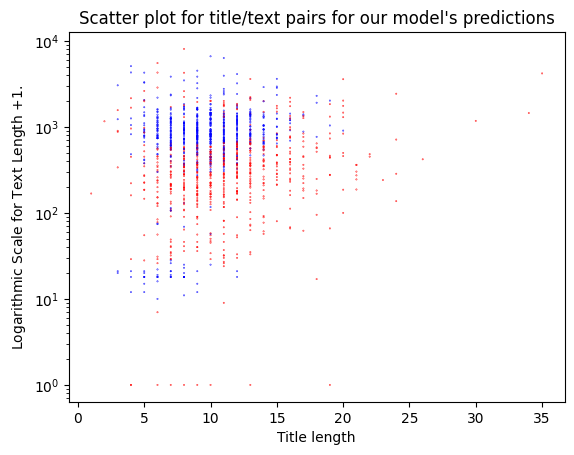

In [629]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
scatter = pyplot.scatter(X_test['title_word_count'],X_test['text_word_count']+1, c = np.vectorize(colour.get)(prediction), s=0.4, marker='.')
pyplot.xlabel('Title length')
pyplot.ylabel('Logarithmic Scale for Text Length $+ 1$.')
pyplot.yscale('log')
pyplot.title('Scatter plot for title/text pairs for our model\'s predictions')
pyplot.show()